# Week 2: Baseline Modeling with Logistic Regression

## Objectives
1. Load the processed dataset from Week 1
2. Split data into train/test sets with stratification
3. Scale features appropriately
4. Train a dummy baseline classifier
5. Train logistic regression with class balancing
6. Evaluate models comprehensively
7. Interpret model coefficients
8. Save model and results

## Timeline
**Week 2 (Nov 25 - Dec 1)** - Due: Dec 1

---

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Set up paths
project_root = Path.cwd().parent
data_dir = project_root / 'data'
processed_data_dir = data_dir / 'processed'
models_dir = project_root / 'models'
figures_dir = project_root / 'figures'

# Create directories
models_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Models directory: {models_dir}")

Project root: C:\Users\FR33STYLE\FeatureBeats
Models directory: C:\Users\FR33STYLE\FeatureBeats\models


## 1. Load Processed Dataset

In [3]:
# Load the dataset created in Week 1
data_file = processed_data_dir / 'hits_dataset.csv'

if not data_file.exists():
    raise FileNotFoundError(
        f"❌ Dataset not found at {data_file}\n"
        "Please run notebook 01_Week1_Data_Setup_EDA.ipynb first!"
    )

df = pd.read_csv(data_file)
print(f"✅ Loaded dataset: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nClass distribution:")
print(df['is_hit'].value_counts())
print(f"\nFirst few rows:")
df.head()

✅ Loaded dataset: (113999, 13)

Columns: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'is_hit', 'year', 'track_name', 'artists']

Class distribution:
is_hit
0    111861
1      2138
Name: count, dtype: int64

First few rows:


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,is_hit,year,track_name,artists
0,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,0,2015,Comedy,Gen Hoshino
1,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,0,2015,Ghost - Acoustic,Ben Woodward
2,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,0,2015,To Begin Again,Ingrid Michaelson;ZAYN
3,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,0,2015,Can't Help Falling In Love,Kina Grannis
4,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,1,2015,Hold On,Chord Overstreet


## 2. Prepare Features and Target

In [4]:
# Identify feature columns (numeric columns except target and metadata)
# Exclude: is_hit, year, track names, artist names
exclude_cols = ['is_hit', 'year']

# Also exclude any text columns
text_cols = df.select_dtypes(include=['object']).columns.tolist()
exclude_cols.extend(text_cols)

# Get feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

# Prepare X and y
X = df[feature_cols].values
y = df['is_hit'].values

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nTarget distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y)*100:.2f}%)")

Feature columns (9):
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

X shape: (113999, 9)
y shape: (113999,)

Target distribution:
  Class 0: 111,861 (98.12%)
  Class 1: 2,138 (1.88%)


## 3. Train/Test Split

**Important:** We use stratified split to maintain class balance in both sets.

In [5]:
# Stratified train/test split
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_SEED,
    stratify=y  # Maintain class distribution
)

print(f"Train set size: {len(X_train):,} ({(1-TEST_SIZE)*100:.0f}%)")
print(f"Test set size:  {len(X_test):,} ({TEST_SIZE*100:.0f}%)")

print(f"\nTrain set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train)*100:.2f}%)")

print(f"\nTest set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_test)*100:.2f}%)")

Train set size: 91,199 (80%)
Test set size:  22,800 (20%)

Train set class distribution:
  Class 0: 89,489 (98.12%)
  Class 1: 1,710 (1.88%)

Test set class distribution:
  Class 0: 22,372 (98.12%)
  Class 1: 428 (1.88%)


## 4. Feature Scaling

Logistic regression benefits from scaled features (mean=0, std=1).

In [6]:
# Fit scaler on training data only (avoid data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")
print(f"\nTraining set statistics (after scaling):")
print(f"  Mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"  Std:  {X_train_scaled.std():.6f} (should be ~1)")

# Save scaler for future use
joblib.dump(scaler, models_dir / 'scaler.pkl')
print(f"\n✅ Saved scaler to {models_dir / 'scaler.pkl'}")

✅ Features scaled

Training set statistics (after scaling):
  Mean: 0.000000 (should be ~0)
  Std:  1.000000 (should be ~1)

✅ Saved scaler to C:\Users\FR33STYLE\FeatureBeats\models\scaler.pkl


## 5. Baseline Model: Dummy Classifier

Before building a real model, let's establish a baseline using a simple strategy.

In [7]:
# Dummy classifier (predicts most frequent class)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
dummy_clf.fit(X_train_scaled, y_train)
y_pred_dummy = dummy_clf.predict(X_test_scaled)

print("DUMMY CLASSIFIER RESULTS (Baseline)")
print("="*60)
print(f"Strategy: Always predict most frequent class")
print(f"\nAccuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_dummy, zero_division=0):.4f}")

print(f"\n⚠️  This is our baseline to beat!")
print(f"    A good model should perform significantly better than this.")

DUMMY CLASSIFIER RESULTS (Baseline)
Strategy: Always predict most frequent class

Accuracy:  0.9812
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

⚠️  This is our baseline to beat!
    A good model should perform significantly better than this.


## 6. Logistic Regression with Class Balancing

**Key Strategy:** Use `class_weight='balanced'` to handle class imbalance.

This automatically adjusts weights to be inversely proportional to class frequencies.

In [8]:
# Train logistic regression
print("Training Logistic Regression...\n")

logreg = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='lbfgs'
)

logreg.fit(X_train_scaled, y_train)

print("✅ Model trained successfully")

# Make predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

print("✅ Predictions generated")

Training Logistic Regression...

✅ Model trained successfully
✅ Predictions generated


## 7. Model Evaluation

### 7.1 Basic Metrics

In [9]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}  ← Overall correctness")
print(f"Precision: {precision:.4f}  ← Of predicted hits, how many are correct?")
print(f"Recall:    {recall:.4f}  ← Of actual hits, how many did we catch?")
print(f"F1 Score:  {f1:.4f}  ← Harmonic mean of precision and recall")
print(f"ROC-AUC:   {roc_auc:.4f}  ← Overall discrimination ability")
print(f"PR-AUC:    {pr_auc:.4f}  ← Precision-recall trade-off (better for imbalanced data)")

print(f"\n⚠️  For imbalanced data, focus on:")
print(f"   • Recall (catch as many hits as possible)")
print(f"   • F1 Score (balance precision and recall)")
print(f"   • PR-AUC (more informative than ROC-AUC for imbalanced data)")

LOGISTIC REGRESSION RESULTS
Accuracy:  0.6198  ← Overall correctness
Precision: 0.0394  ← Of predicted hits, how many are correct?
Recall:    0.8224  ← Of actual hits, how many did we catch?
F1 Score:  0.0751  ← Harmonic mean of precision and recall
ROC-AUC:   0.7688  ← Overall discrimination ability
PR-AUC:    0.0546  ← Precision-recall trade-off (better for imbalanced data)

⚠️  For imbalanced data, focus on:
   • Recall (catch as many hits as possible)
   • F1 Score (balance precision and recall)
   • PR-AUC (more informative than ROC-AUC for imbalanced data)


### 7.2 Confusion Matrix

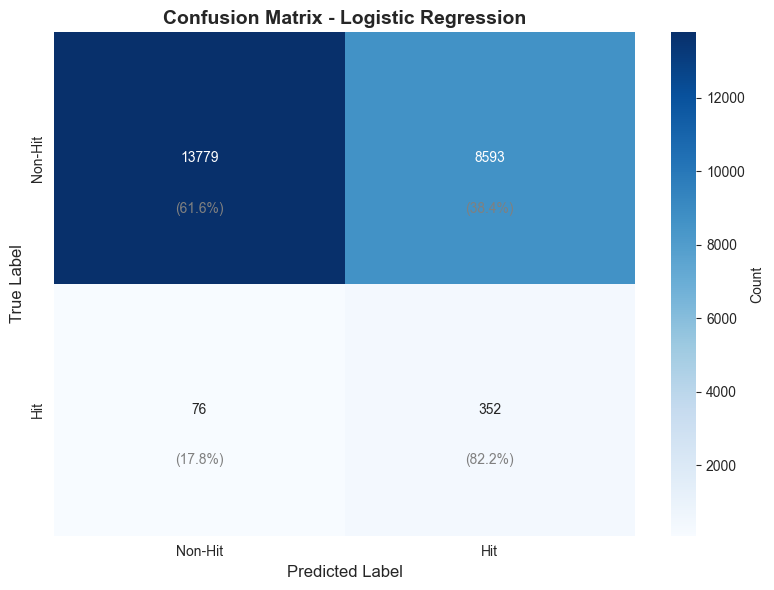

✅ Saved: logreg_confusion_matrix.png

Confusion Matrix Breakdown:
  True Negatives  (TN): 13,779  ← Correctly predicted non-hits
  False Positives (FP): 8,593  ← Non-hits wrongly predicted as hits
  False Negatives (FN): 76  ← Hits wrongly predicted as non-hits
  True Positives  (TP): 352  ← Correctly predicted hits


In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig(figures_dir / 'logreg_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: logreg_confusion_matrix.png")

# Print detailed breakdown
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives  (TN): {cm[0, 0]:,}  ← Correctly predicted non-hits")
print(f"  False Positives (FP): {cm[0, 1]:,}  ← Non-hits wrongly predicted as hits")
print(f"  False Negatives (FN): {cm[1, 0]:,}  ← Hits wrongly predicted as non-hits")
print(f"  True Positives  (TP): {cm[1, 1]:,}  ← Correctly predicted hits")

### 7.3 Classification Report

In [11]:
# Detailed classification report
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=['Non-Hit', 'Hit'],
                          digits=4))

Classification Report:
              precision    recall  f1-score   support

     Non-Hit     0.9945    0.6159    0.7607     22372
         Hit     0.0394    0.8224    0.0751       428

    accuracy                         0.6198     22800
   macro avg     0.5169    0.7192    0.4179     22800
weighted avg     0.9766    0.6198    0.7478     22800



### 7.4 ROC Curve

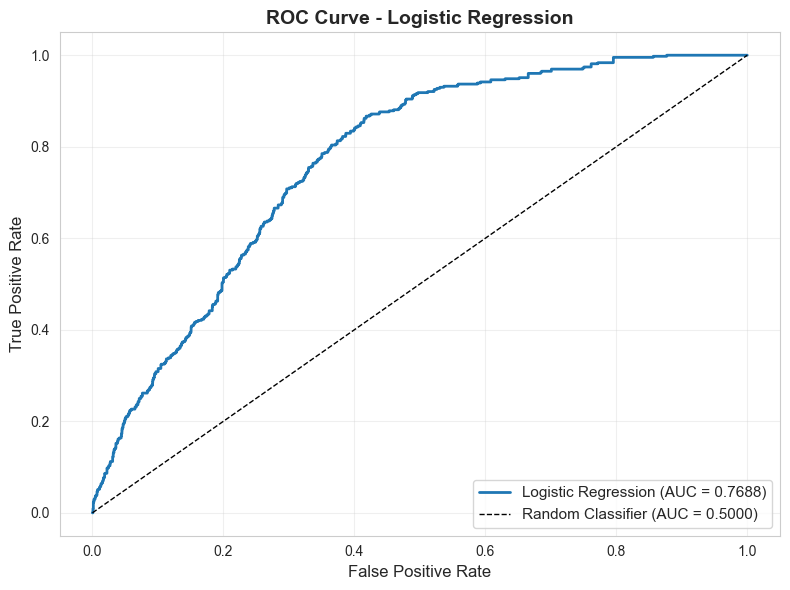

✅ Saved: logreg_roc_curve.png


In [12]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'logreg_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: logreg_roc_curve.png")

### 7.5 Precision-Recall Curve

**More informative than ROC for imbalanced datasets!**

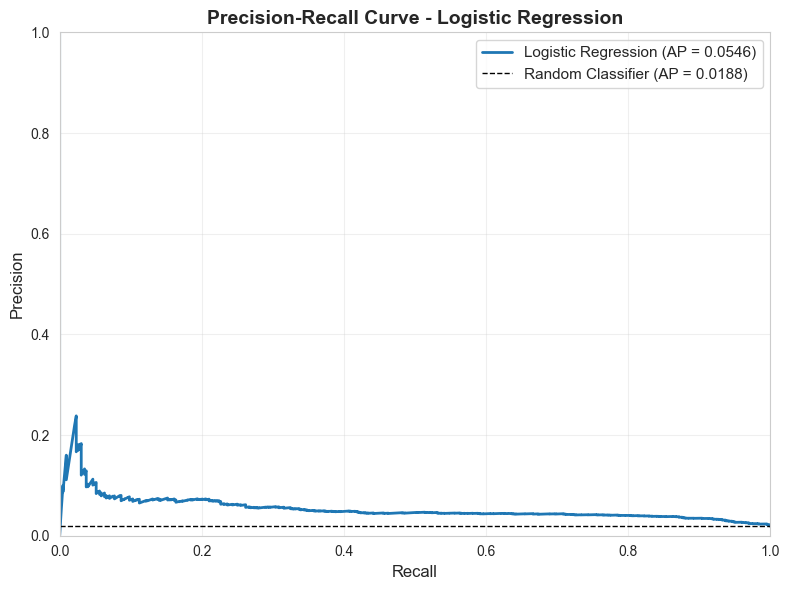

✅ Saved: logreg_pr_curve.png


In [13]:
# Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(recall_curve, precision_curve, linewidth=2, 
        label=f'Logistic Regression (AP = {pr_auc:.4f})')

# Baseline (random classifier for imbalanced data)
baseline = (y_test == 1).sum() / len(y_test)
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1,
          label=f'Random Classifier (AP = {baseline:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(figures_dir / 'logreg_pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: logreg_pr_curve.png")

## 8. Feature Importance (Coefficients)

Logistic regression coefficients tell us which features are most important for predicting hits.

In [14]:
# Get coefficients
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logreg.coef_[0]
})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("Feature Coefficients (sorted by absolute value):")
print("="*60)
for idx, row in coefficients.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"{row['Feature']:20s} {row['Coefficient']:+.4f}  ← {direction} hit probability")

print(f"\nInterpretation:")
print(f"  • Positive coefficient: Higher feature value → More likely to be a HIT")
print(f"  • Negative coefficient: Higher feature value → More likely to be a NON-HIT")
print(f"  • Larger absolute value: Stronger effect")

Feature Coefficients (sorted by absolute value):
loudness             +1.2504  ← increases hit probability
instrumentalness     -1.1261  ← decreases hit probability
acousticness         -0.5585  ← decreases hit probability
energy               -0.5584  ← decreases hit probability
danceability         +0.4319  ← increases hit probability
liveness             -0.3102  ← decreases hit probability
valence              -0.2742  ← decreases hit probability
speechiness          -0.1800  ← decreases hit probability
tempo                +0.0290  ← increases hit probability

Interpretation:
  • Positive coefficient: Higher feature value → More likely to be a HIT
  • Negative coefficient: Higher feature value → More likely to be a NON-HIT
  • Larger absolute value: Stronger effect


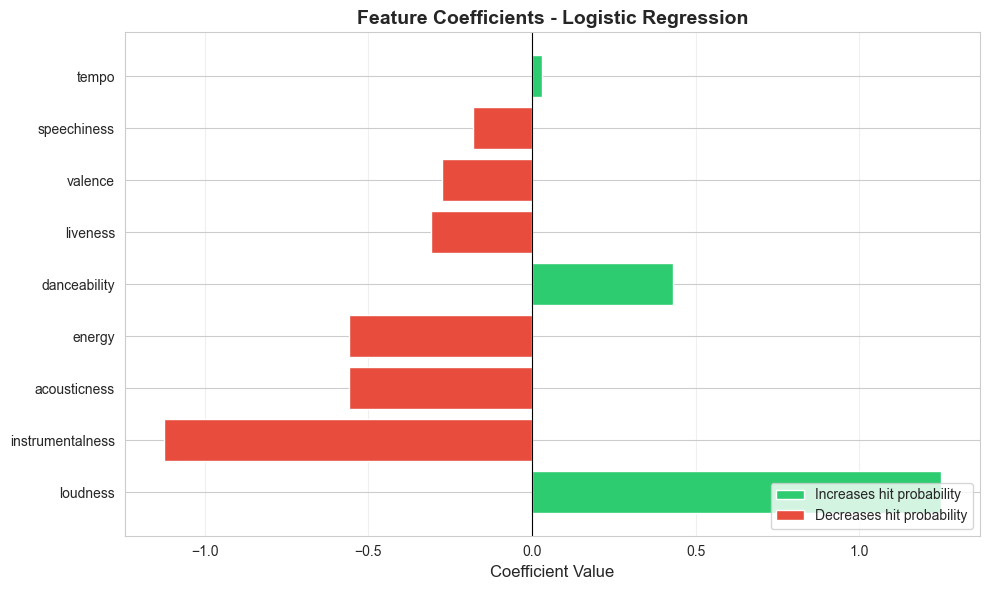

✅ Saved: logreg_coefficients.png


In [15]:
# Visualize coefficients
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coefficients['Coefficient']]
bars = ax.barh(range(len(coefficients)), coefficients['Coefficient'], color=colors)

ax.set_yticks(range(len(coefficients)))
ax.set_yticklabels(coefficients['Feature'])
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Feature Coefficients - Logistic Regression', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Increases hit probability'),
    Patch(facecolor='#e74c3c', label='Decreases hit probability')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(figures_dir / 'logreg_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: logreg_coefficients.png")

## 9. Save Model

In [16]:
# Save the trained model
model_file = models_dir / 'baseline_logreg.pkl'
joblib.dump(logreg, model_file)

print(f"✅ Saved model to: {model_file}")

# Save metrics for comparison later
metrics = {
    'model': 'Logistic Regression',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(models_dir / 'baseline_metrics.csv', index=False)
print(f"✅ Saved metrics to: {models_dir / 'baseline_metrics.csv'}")

✅ Saved model to: C:\Users\FR33STYLE\FeatureBeats\models\baseline_logreg.pkl
✅ Saved metrics to: C:\Users\FR33STYLE\FeatureBeats\models\baseline_metrics.csv


## 10. Summary Report

In [17]:
print("="*80)
print("WEEK 2 SUMMARY REPORT")
print("="*80)

print(f"\n1. MODEL PERFORMANCE")
print(f"\n   Dummy Baseline (Most Frequent):")
print(f"     Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"     F1 Score: {f1_score(y_test, y_pred_dummy, zero_division=0):.4f}")

print(f"\n   Logistic Regression (Balanced):")
print(f"     Accuracy:  {accuracy:.4f}")
print(f"     Precision: {precision:.4f}")
print(f"     Recall:    {recall:.4f}")
print(f"     F1 Score:  {f1:.4f}")
print(f"     ROC-AUC:   {roc_auc:.4f}")
print(f"     PR-AUC:    {pr_auc:.4f}")

print(f"\n2. KEY INSIGHTS")
print(f"\n   Top 3 Positive Predictors (increase hit probability):")
top_positive = coefficients[coefficients['Coefficient'] > 0].head(3)
for i, (idx, row) in enumerate(top_positive.iterrows(), 1):
    print(f"     {i}. {row['Feature']}: {row['Coefficient']:+.4f}")

print(f"\n   Top 3 Negative Predictors (decrease hit probability):")
top_negative = coefficients[coefficients['Coefficient'] < 0].head(3)
for i, (idx, row) in enumerate(top_negative.iterrows(), 1):
    print(f"     {i}. {row['Feature']}: {row['Coefficient']:+.4f}")

print(f"\n3. MODEL STRENGTHS & WEAKNESSES")
if recall > 0.6:
    print(f"   ✅ Good recall: Catching {recall*100:.1f}% of actual hits")
else:
    print(f"   ⚠️  Low recall: Only catching {recall*100:.1f}% of actual hits")

if precision > 0.5:
    print(f"   ✅ Decent precision: {precision*100:.1f}% of predicted hits are correct")
else:
    print(f"   ⚠️  Low precision: Only {precision*100:.1f}% of predicted hits are correct")

print(f"\n4. NEXT STEPS (Week 3)")
print(f"   → Train XGBoost model (handle non-linear patterns)")
print(f"   → Hyperparameter tuning")
print(f"   → SHAP analysis for deeper interpretation")
print(f"   → Compare XGBoost vs Logistic Regression")

print(f"\n5. FILES CREATED")
print(f"   → {model_file}")
print(f"   → {models_dir / 'scaler.pkl'}")
print(f"   → {figures_dir / 'logreg_confusion_matrix.png'}")
print(f"   → {figures_dir / 'logreg_roc_curve.png'}")
print(f"   → {figures_dir / 'logreg_pr_curve.png'}")
print(f"   → {figures_dir / 'logreg_coefficients.png'}")

print("\n" + "="*80)
print("✅ WEEK 2 COMPLETE - Baseline model established!")
print("="*80)

WEEK 2 SUMMARY REPORT

1. MODEL PERFORMANCE

   Dummy Baseline (Most Frequent):
     Accuracy: 0.9812
     F1 Score: 0.0000

   Logistic Regression (Balanced):
     Accuracy:  0.6198
     Precision: 0.0394
     Recall:    0.8224
     F1 Score:  0.0751
     ROC-AUC:   0.7688
     PR-AUC:    0.0546

2. KEY INSIGHTS

   Top 3 Positive Predictors (increase hit probability):
     1. loudness: +1.2504
     2. danceability: +0.4319
     3. tempo: +0.0290

   Top 3 Negative Predictors (decrease hit probability):
     1. instrumentalness: -1.1261
     2. acousticness: -0.5585
     3. energy: -0.5584

3. MODEL STRENGTHS & WEAKNESSES
   ✅ Good recall: Catching 82.2% of actual hits
   ⚠️  Low precision: Only 3.9% of predicted hits are correct

4. NEXT STEPS (Week 3)
   → Train XGBoost model (handle non-linear patterns)
   → Hyperparameter tuning
   → SHAP analysis for deeper interpretation
   → Compare XGBoost vs Logistic Regression

5. FILES CREATED
   → C:\Users\FR33STYLE\FeatureBeats\models\bas

---

## ✅ Week 2 Deliverables Complete!

You now have:
1. ✅ Trained logistic regression baseline
2. ✅ Comprehensive evaluation metrics
3. ✅ Feature importance analysis
4. ✅ Multiple visualizations
5. ✅ Saved model for future comparison

### Key Takeaways:
- Logistic regression provides an **interpretable** baseline
- Class balancing helps handle imbalanced data
- For imbalanced data, **F1, Recall, and PR-AUC** are more important than accuracy
- Coefficients reveal which audio features matter most for hits

### Next Steps:
Proceed to **03_Week3_XGBoost_SHAP.ipynb** for advanced modeling with XGBoost and SHAP interpretation.

---